# Getting Started with Trax

Author: Henry Allen

## Setup

pip install necessary packages

In [1]:

! pip install -q -U trax
! pip install -q tensorflow


     |████████████████████████████████| 317kB 9.0MB/s 


import necessary packages

In [2]:
#@title
# Copyright 2020 Google LLC.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import trax

import trax.layers as tl
import pandas as pd
import urllib
import cv2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## MNIST Multi-layer Perceptron

This example shows a basic multi-layer perceptron training on the MNIST dataset

### Import mnist training data

In [0]:
data = np.genfromtxt("sample_data/mnist_train_small.csv", delimiter=',')

label = data[:, 0]
print(label.shape)

train = data[:, 1:]
print(train.shape)

(20000,)
(20000, 784)


### Classifier Setup


Trax trains data on input streams, implemented as iterators.

In [0]:
def mnist_iterator(batch_size):
"""
Generator to stream data values from the training set
"""
  count = 0
  while True:
    mask = np.array([1])
    X = train[count * batch_size: count * batch_size + batch_size]
    y = label[count * batch_size: count * batch_size + batch_size]
    count += 1
    count = count % 20000
    yield (X, y.reshape(batch_size, 1), mask)

copy_inputs = trax.supervised.Inputs(lambda _: mnist_iterator(1))

# Peek into the inputs.
data_stream = copy_inputs.train_stream(1)
inputs, labels, mask = next(data_stream)
print(inputs.shape)
print(labels.shape)

(1, 784)
(1, 1)


### Model Training

In [0]:
# Resnet Model
#TODO: Get this working on MNIST


# Multi-layer perceptron model
def mlp_model(mode):
  return trax.models.MLP(d_hidden=784, mode=mode)

output_dir = os.path.expanduser('~/train_dir/')
!rm -f ~/train_dir/model.pkl  # Remove old model.

# Create the Trainer, initialize with model, data, loss_fn, and optimizer
# TODO Get Triplet Loss
trainer = trax.supervised.Trainer(
    model=mlp_model,
    loss_fn=trax.layers.CrossEntropyLoss,
    optimizer=trax.optimizers.Adafactor,  # Change optimizer params here.
    lr_schedule=trax.lr.MultifactorSchedule,  # Change lr schedule here.
    inputs=copy_inputs,
    output_dir=output_dir,
    has_weights=True)  # Because we have loss mask, this API may change.

# Train for 3 epochs each consisting of 500 train batches, eval on 2 batches.
n_epochs  = 20
train_steps = 1000
eval_steps = 2
for _ in range(n_epochs):
  trainer.train_epoch(train_steps, eval_steps)

### Inference

In [0]:
# Initialize model for inference.
predict_model = mlp_model(mode='predict')
predict_signature = trax.shapes.ShapeDtype((1,784), dtype=np.int32)
predict_model.init(predict_signature)
predict_model.weights = trainer.model_weights


5


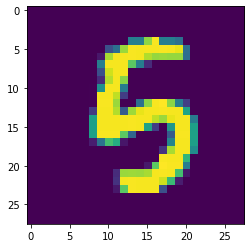

In [0]:
X_pred = train[9]
print(np.argmax(predict_model(X_pred.reshape(1,784))))
plt.imshow(X_pred.reshape(28, 28))

## Dummy Data Resnet50


In [0]:
def gen_resnet50():
  while True:
    X = np.random.randint(255, size=(1, 224, 224, 3))
    mask = np.array([1])
    y = np.array([5])
    yield (X, y, mask)

def resnet50_model(mode):
  return trax.models.Resnet50(n_output_classes=10, mode=mode)


In [5]:
resnet_inputs = trax.supervised.Inputs(lambda _: gen_resnet50())

data_stream = resnet_inputs.train_stream(1)
inputs, labels, mask = next(data_stream)
print(inputs.shape)
print(labels.shape)

(1, 224, 224, 3)
(1,)


In [0]:
output_dir = os.path.expanduser('~/train_dir/')
!rm -f ~/train_dir/model.pkl  # Remove old model.

# Create the Trainer, initialize with model, data, loss_fn, and optimizer
trainer = trax.supervised.Trainer(
    model=resnet50_model,
    loss_fn=trax.layers.CrossEntropyLoss,
    optimizer=trax.optimizers.Adafactor,  # Change optimizer params here.
    lr_schedule=trax.lr.MultifactorSchedule,  # Change lr schedule here.
    inputs=resnet_inputs,
    output_dir=output_dir,
    has_weights=True)  # Because we have loss mask, this API may change.

# Train for 3 epochs each consisting of 500 train batches, eval on 2 batches.
n_epochs  = 2
train_steps = 10
eval_steps = 2
for _ in range(n_epochs):
  trainer.train_epoch(train_steps, eval_steps)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4622: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))



Step     10: Ran 10 train steps in 86.80 secs
Step     10: Evaluation
Step     10: train                   accuracy |  0.00000000
Step     10: train                       loss |  11019.67871094
Step     10: train         neg_log_perplexity |  11019.67871094
Step     10: train weights_per_batch_per_core |  1.00000000
Step     10: eval                    accuracy |  0.00000000
Step     10: eval                        loss |  10902.46289062
Step     10: eval          neg_log_perplexity |  10902.46289062
Step     10: eval  weights_per_batch_per_core |  1.00000000
Step     10: Finished evaluation

Step     20: Ran 10 train steps in 0.54 secs
Step     20: Evaluation
Step     20: train                   accuracy |  0.00000000
Step     20: train                       loss |  4358.71875000
Step     20: train         neg_log_perplexity |  4358.71875000
Step     20: train weights_per_batch_per_core |  1.00000000
Step     20: eval                    accuracy |  0.00000000
Step     20: eval       

In [0]:
predict_model = resnet50_model(mode='predict')
predict_signature = trax.shapes.ShapeDtype((1,224,224,3), dtype=np.int32)
predict_model.init(predict_signature)
predict_model.weights = trainer.model_weights

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4622: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [0]:
X_pred = np.random.randint(255, size=(1, 224, 224, 3))
print(predict_model(X_pred))

[[ -81249.03 -262850.75       0.   -174274.62 -224923.   -232669.06
  -345881.3  -169060.97 -440464.84 -502365.5 ]]


## Resnet with Embedding Output

In [0]:
from trax.models.resnet import ConvBlock
from trax.models.resnet import IdentityBlock


# Forked from trax, just to help get set up
def ImageFEC(d_hidden=64,
             n_output_classes=1001,
             mode='train',
             norm=tl.BatchNorm,
             non_linearity=tl.Relu):
  """ResNet.
  Args:
    d_hidden: Dimensionality of the first hidden layer (multiplied later).
    n_output_classes: Number of distinct output classes.
    mode: Whether we are training or evaluating or doing inference.
    norm: `Layer` used for normalization, Ex: BatchNorm or
      FilterResponseNorm.
    non_linearity: `Layer` used as a non-linearity, Ex: If norm is
      BatchNorm then this is a Relu, otherwise for FilterResponseNorm this
      should be ThresholdedLinearUnit.
  Returns:
    The list of layers comprising a ResNet model with the given parameters.
  """

  # A ConvBlock configured with the given norm, non-linearity and mode.
  def Resnet50ConvBlock(filter_multiplier=1, strides=(2, 2)):
    filters = ([
        filter_multiplier * dim for dim in [d_hidden, d_hidden, 4 * d_hidden]
    ])
    return ConvBlock(3, filters, strides, norm, non_linearity, mode)

  # Same as above for IdentityBlock.
  def Resnet50IdentityBlock(filter_multiplier=1):
    filters = ([
        filter_multiplier * dim for dim in [d_hidden, d_hidden, 4 * d_hidden]
    ])
    return IdentityBlock(3, filters, norm, non_linearity, mode)

  return tl.Serial(
      tl.ToFloat(),
      tl.Conv(d_hidden, (7, 7), (2, 2), 'SAME'),
      norm(mode=mode),
      non_linearity(),
      tl.MaxPool(pool_size=(3, 3), strides=(2, 2)),
      Resnet50ConvBlock(strides=(1, 1)),
      [Resnet50IdentityBlock() for _ in range(2)],
      Resnet50ConvBlock(2),
      [Resnet50IdentityBlock(2) for _ in range(3)],
      Resnet50ConvBlock(4),
      [Resnet50IdentityBlock(4) for _ in range(5)],
      Resnet50ConvBlock(8),
      [Resnet50IdentityBlock(8) for _ in range(2)],
      tl.AvgPool(pool_size=(7, 7)),
      tl.Flatten(),
      tl.Dense(16),
      #tl.BatchNorm(axis=0)
      tl.LayerNorm(),
      #tl.LogSoftmax(),
  )

In [0]:
def gen_image_fec():
  while True:
    X = np.random.randint(255, size=(1, 224, 224, 3))
    mask = np.array([1])
    y = np.ones((1,16)) / np.sqrt(16)
    yield (X, y, mask)

def image_fec_model(mode):
  return ImageFEC(mode=mode)

In [98]:
resnet_inputs = trax.supervised.Inputs(lambda _: gen_image_fec())

data_stream = resnet_inputs.train_stream(1)
inputs, labels, mask = next(data_stream)
print(inputs.shape)
print(labels.shape)

(1, 224, 224, 3)
(1, 16)


In [99]:
output_dir = os.path.expanduser('~/train_dir/')
!rm -f ~/train_dir/model.pkl  # Remove old model.

# Create the Trainer, initialize with model, data, loss_fn, and optimizer
trainer = trax.supervised.Trainer(
    model=image_fec_model,
    loss_fn=trax.layers.CrossEntropyLoss,
    optimizer=trax.optimizers.Adafactor,  # Change optimizer params here.
    lr_schedule=trax.lr.MultifactorSchedule,  # Change lr schedule here.
    inputs=resnet_inputs,
    output_dir=output_dir,
    has_weights=True)  # Because we have loss mask, this API may change.

# Train for 3 epochs each consisting of 500 train batches, eval on 2 batches.
n_epochs  = 2
train_steps = 10
eval_steps = 2
for _ in range(n_epochs):
  trainer.train_epoch(train_steps, eval_steps)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4622: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))



Step     10: Ran 10 train steps in 88.73 secs
Step     10: Evaluation
Step     10: train                   accuracy |  0.00000000
Step     10: train                       loss |  0.00000000
Step     10: train         neg_log_perplexity |  0.00000000
Step     10: train weights_per_batch_per_core |  16.00000000
Step     10: eval                    accuracy |  0.00000000
Step     10: eval                        loss |  0.00000000
Step     10: eval          neg_log_perplexity |  0.00000000
Step     10: eval  weights_per_batch_per_core |  16.00000000
Step     10: Finished evaluation

Step     20: Ran 10 train steps in 0.54 secs
Step     20: Evaluation
Step     20: train                   accuracy |  0.00000000
Step     20: train                       loss |  0.00000000
Step     20: train         neg_log_perplexity |  0.00000000
Step     20: train weights_per_batch_per_core |  16.00000000
Step     20: eval                    accuracy |  0.00000000
Step     20: eval                        lo

In [81]:
predict_model = image_fec_model(mode='predict')
predict_signature = trax.shapes.ShapeDtype((1,224,224,3), dtype=np.int32)
predict_model.init(predict_signature)
predict_model.weights = trainer.model_weights

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4622: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [82]:
X_pred = np.random.randint(255, size=(1, 224, 224, 3))
y_pred = predict_model(X_pred)
print(y_pred.shape)
print(y_pred)

(1, 16)
[[  99539.86   -78613.05    18691.195  333988.25    20243.775 -211312.16
  -371872.     -27524.047  256631.48   304937.7    341741.78  -127014.3
   -30517.047 -147248.38   -16032.406 -237722.69 ]]


## Triplet Image Resnet50

Import Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
face_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/faceexp-comparison-data-train-public.csv", index_col=False, header=None)
face_train = face_train.drop(columns = [28,29,30,31,32,33,34,35,36,37])
face_train["label"] = face_train.loc[:,[17,19,21,23,25]].mode(axis=1).loc[:, 0]
face_train = face_train.drop(columns=[17,19,21,23,25,27])


In [0]:
face_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,22,24,26,label
0,http://farm5.staticflickr.com/4108/5185055338_...,0.142578,0.266602,0.065421,0.297508,http://farm3.staticflickr.com/2127/5765052001_...,0.439490,0.596178,0.289062,0.427734,http://farm4.staticflickr.com/3747/8914150145_...,0.345703,0.453125,0.075110,0.262150,ONE_CLASS_TRIPLET,269701,291701,321402,321501,321902,322102,2.0
1,http://farm5.staticflickr.com/4108/5185055338_...,0.142578,0.266602,0.065421,0.297508,http://farm4.staticflickr.com/3543/3387356856_...,0.335938,0.441406,0.130307,0.311859,http://farm4.staticflickr.com/3674/9280612097_...,0.359307,0.562771,0.514648,0.673828,TWO_CLASS_TRIPLET,291701,321402,321601,4295017797,4295017896,48316,2.0
2,http://farm5.staticflickr.com/4108/5185055338_...,0.142578,0.266602,0.065421,0.297508,http://farm4.staticflickr.com/3858/14540292875...,0.206442,0.524158,0.078125,0.325195,http://farm5.staticflickr.com/4116/4747184973_...,0.387695,0.547852,0.184694,0.380612,ONE_CLASS_TRIPLET,300901,321902,322102,4295017797,4295017896,48316,1.0
3,http://farm5.staticflickr.com/4108/5185055338_...,0.718750,0.826172,0.194704,0.394081,http://farm4.staticflickr.com/3875/14501588548...,0.318665,0.488619,0.162109,0.290039,http://farm1.staticflickr.com/89/241047479_eb0...,0.290000,0.430000,0.197333,0.413333,TWO_CLASS_TRIPLET,321402,321501,321601,321902,322102,48316,3.0
4,http://farm5.staticflickr.com/4108/5185055338_...,0.718750,0.826172,0.194704,0.394081,http://farm6.staticflickr.com/5143/5693754914_...,0.244141,0.380859,0.175000,0.413235,http://farm4.staticflickr.com/3666/12590745114...,0.250000,0.371094,0.242291,0.453745,ONE_CLASS_TRIPLET,269701,321501,321601,321902,322102,41207,2.0


Image Generation Stream

In [0]:
def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)

  return image

def get_image(offset, train_data):
  img = url_to_image(train_data[0 + offset])
  x0 = int(img.shape[0] * train_data[1 + offset])
  y0 = int(img.shape[1] * train_data[2 + offset])
  x1 = int(img.shape[0] * train_data[3 + offset])
  y1 = int(img.shape[1] * train_data[4 + offset])

  img = img[min(y0,y1):max(y0,y1), min(x0,x1):max(x0, x1)]
  img = cv2.resize(img, (224, 224)) 
  return img

def image_iterator():
  count = 0
  while True:
    train_data = face_train.loc[count]
    mask = np.array([1])
    triplet = np.zeros((3, 224, 224, 3))
    
    triplet[0] = get_image(0, train_data)
    triplet[1] = get_image(5, train_data)
    triplet[2] = get_image(10, train_data)

    label = np.array([face_train.loc[count, "label"]])
    count+=1
    yield (triplet, label, mask)


In [0]:
resnet_inputs = trax.supervised.Inputs(lambda _: image_iterator())

data_stream = resnet_inputs.train_stream(1)
inputs, labels, mask = next(data_stream)
print(inputs.shape)
print(labels.shape)

(3, 224, 224, 3)
(1,)


### Train the Model

In [0]:
output_dir = os.path.expanduser('~/train_dir/')
!rm -f ~/train_dir/model.pkl  # Remove old model.

# Create the Trainer, initialize with model, data, loss_fn, and optimizer
# TODO Get Triplet Loss
trainer = trax.supervised.Trainer(
    model=resnet50_model,
    loss_fn=trax.layers.CrossEntropyLoss, #TODO: Change this
    optimizer=trax.optimizers.Adafactor, 
    lr_schedule=trax.lr.MultifactorSchedule, 
    inputs=resnet_inputs,
    output_dir=output_dir,
    has_weights=True) 

# Train for 3 epochs each consisting of 500 train batches, eval on 2 batches.
n_epochs  = 2
train_steps = 4
eval_steps = 2
for _ in range(n_epochs):
  trainer.train_epoch(train_steps, eval_steps)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4622: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))



Step      4: Ran 4 train steps in 103.21 secs
Step      4: Evaluation
Step      4: train                   accuracy |  0.00000000
Step      4: train                       loss |  59977.21875000
Step      4: train         neg_log_perplexity |  59977.21875000
Step      4: train weights_per_batch_per_core |  1.00000000
Step      4: eval                    accuracy |  0.00000000
Step      4: eval                        loss |  59977.21875000
Step      4: eval          neg_log_perplexity |  59977.21875000
Step      4: eval  weights_per_batch_per_core |  1.00000000
Step      4: Finished evaluation



HTTPError: ignored

### Prediction

### TODO: Implement Triplet Loss

https://en.wikipedia.org/wiki/Triplet_loss

In [0]:
def triplet_loss(triplet, label):
  


In [0]:
trax.layers.CrossEntropyLoss()

## Reformer Model

In [0]:
!gsutil cp gs://trax-ml/reformer/config.gin ./config.gin
gin.parse_config_file('./config.gin')